In [38]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
from sklearn.decomposition import PCA
from collections.abc import Callable
from sympy import symbols, exp, simplify, diff, lambdify

import pickle as pck


%matplotlib inline
%config InlineBackend.figure_format='retina'

## Principal Component Analysis

In [74]:
def pca(X, num_components):
    """ Performs PCA for a given number of components. Returns reduced data and eigenvectors (principal components).

    Parameters:
    -----------
    X : Array to perform PCA on.
    num_components : Number of principal components of interest.
    """
    # subtract mean
    x = X - np.mean(X, axis=0)

    # covariance matrix
    cov_mat = np.cov(x, rowvar=False)

    # Diagonalize covariance matrix
    eigvals, eigvecs = np.linalg.eigh(cov_mat)

    # Sort
    sorted_ids = np.argsort(eigvals)[::-1]
    eigvecs_sorted = eigvecs[:, sorted_ids]

    # Select requested eigenvectors
    eigvecs_selected = eigvecs_sorted[:, 0:num_components]

    # Project data onto eigenvectors
    X_projected = np.dot(eigvecs_selected.transpose(), x.transpose()).transpose()

    return X_projected, eigvecs_selected

## MDSimulation Class

In [140]:
class MDSimulation:
    rng = default_rng(23)
    def __init__(
        self,
        dt: float,
        beta: float,
        lgamma: float,
        dVdx: Callable[[float], float],
        dVdy: Callable[[float], float],
        Ekin: Callable[[float], float],
        in_A: Callable[[float], bool],
        in_B: Callable[[float], bool],
        initial_r: np.array = np.zeros(2)
    ):
        self.dt = dt
        c1 = np.exp(-lgamma*dt/2.0)
        c2 = np.sqrt((1.0-(c1*c1))/beta)
        self.lc = np.array([c1,c2])
        self.r = initial_r
        v = np.sqrt(1.0/beta) * self.rng.standard_normal(size=2)
        scale = np.sqrt(1.0/(beta * Ekin(v)))
        self.v = v*scale
        self.f = np.array([-dVdx(self.r), -dVdy(self.r)])
        self.dVdx = dVdx
        self.dVdy = dVdy
        self.in_A = in_A
        self.in_B = in_B
        
    def run(self, total_steps: int, print_steps: int, position_steps: int):
        
        no_prints = total_steps // print_steps
        no_positions = print_steps // position_steps
        position_slices = total_steps // position_steps

        sum_Ekin = np.zeros(2)
        positions = np.zeros((position_slices, 2))
        for i in range(no_prints):
            for k in range(no_positions):
                for j in range(position_steps):
                    self.mdstep()
                    sum_Ekin += Ekin(self.v)
                positions[(i*no_positions)+k, :] = self.r
            print(f'x = {self.r[0]:.3f}, y = {self.r[1]:.3f}, average beta = {1.0/(sum_Ekin * (i+1) * (no_positions * position_steps))}, A = {self.in_A(self.r)}, B = {self.in_B(self.r)}')

        return positions
    
    def mdstep(self):
        self.v = self.lc[0] * self.v + self.lc[1] * self.rng.standard_normal(size=2)
        self.v = self.v + 0.5 * self.f * self.dt
        self.r = self.r + self.dt * self.v
        self.f = np.array([-self.dVdx(self.r), -self.dVdy(self.r)])
        self.v = self.v + 0.5 * self.f * self.dt
        self.v = self.lc[0] * self.v + self.lc[1] * self.rng.standard_normal(size=2)

## 2D Double Well

In [141]:
def Vpot(r):
    return (r[0]**2 - 1.5)**2 + 0.05*r[1]**2

def dVdx(r):
    return 4*r[0]*(r[0]**2 - 1.5)

def dVdy(r):
    return 0.1*r[1]

def Ekin(v):
    return 0.5*v**2

def in_A(r):
    return r[0] < -0.8
    
def in_B(r):
    return r[0] > 0.8

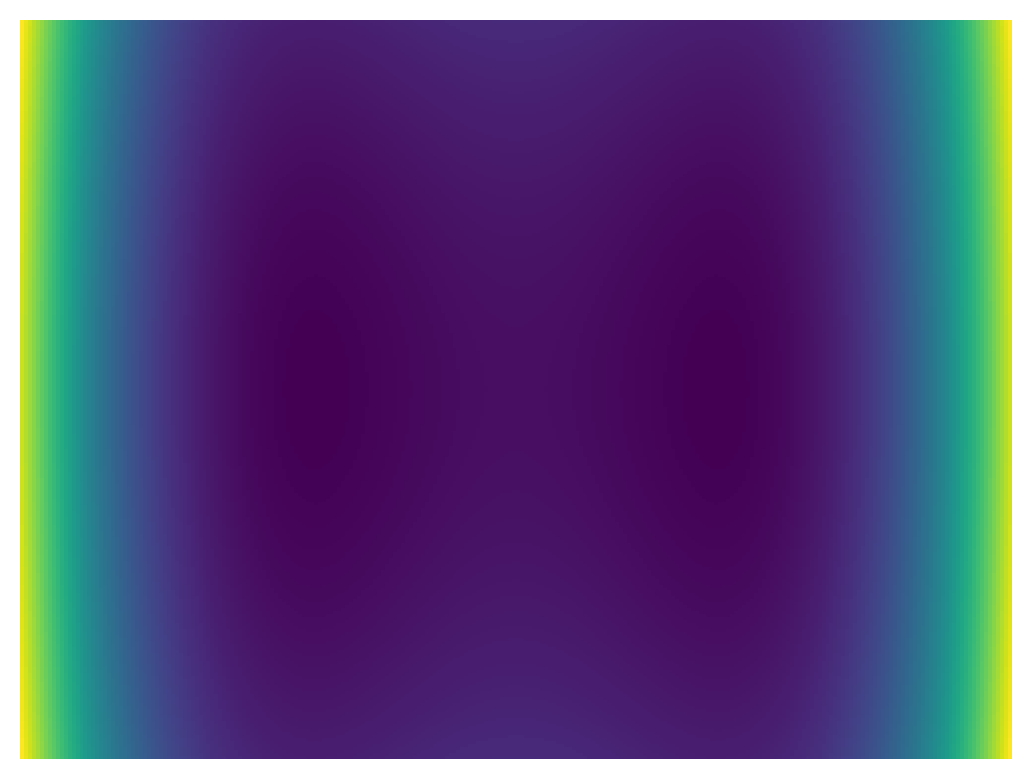

In [174]:
x = np.linspace(-3, 3, 250)
y = np.linspace(-10, 10, 250)
r = np.meshgrid(x, y)

plt.pcolormesh(x, y, Vpot(r))
plt.axis('off')
plt.savefig("vpot_img.png", dpi=600)
plt.show()

In [143]:
mdsim_vpot = MDSimulation(
    0.05,
    3.0,
    1.0,
    dVdx,
    dVdy,
    Ekin,
    in_A,
    in_B
)

positions = mdsim_vpot.run(total_steps=1_000_000, print_steps=100_000, position_steps=100)

x = 1.358, y = 1.392, average beta = [5.96255112e-10 5.92000934e-10], A = False, B = True
x = -1.025, y = -1.262, average beta = [1.49005321e-10 1.47526525e-10], A = True, B = False
x = 0.956, y = 1.214, average beta = [6.61801570e-11 6.64030855e-11], A = False, B = True
x = -0.968, y = -1.669, average beta = [3.70146213e-11 3.73574543e-11], A = True, B = False
x = -0.953, y = 1.189, average beta = [2.37705158e-11 2.37804233e-11], A = True, B = False
x = 1.231, y = -0.568, average beta = [1.65486102e-11 1.63946650e-11], A = False, B = True
x = 1.338, y = -1.677, average beta = [1.21964269e-11 1.21116945e-11], A = False, B = True
x = 1.236, y = -0.911, average beta = [9.32393959e-12 9.27138714e-12], A = False, B = True
x = -1.001, y = -2.476, average beta = [7.42015841e-12 7.34172168e-12], A = True, B = False
x = 1.278, y = 0.056, average beta = [6.00495186e-12 5.97219773e-12], A = False, B = True


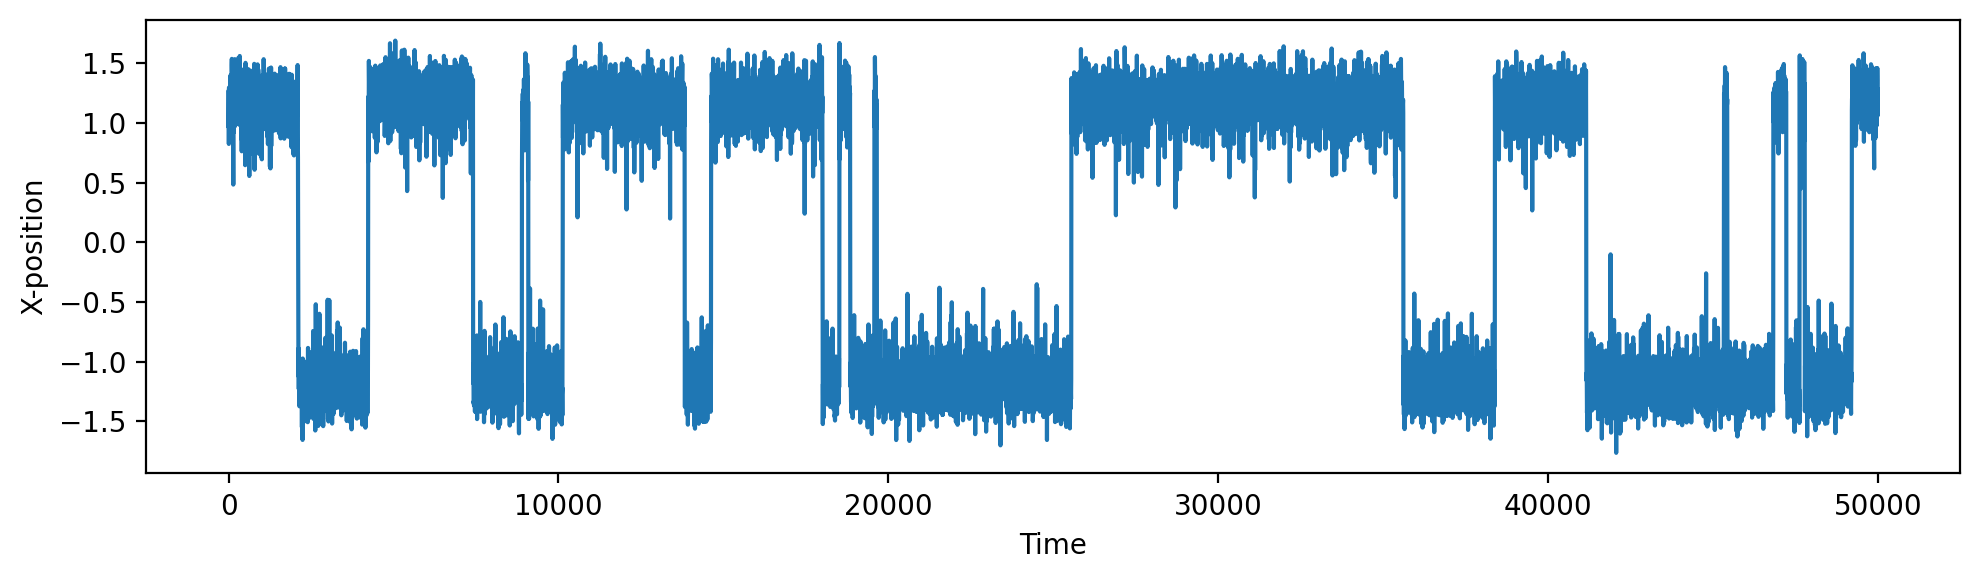

In [144]:
times = np.linspace(0, 0.05*1_000_000, 10_000)
plt.figure(figsize=(10, 3))
plt.plot(times, positions[:, 0])
plt.xlabel("Time")
plt.ylabel("X-position")
plt.tight_layout()
plt.savefig("x_time.png", dpi=600)
plt.show()

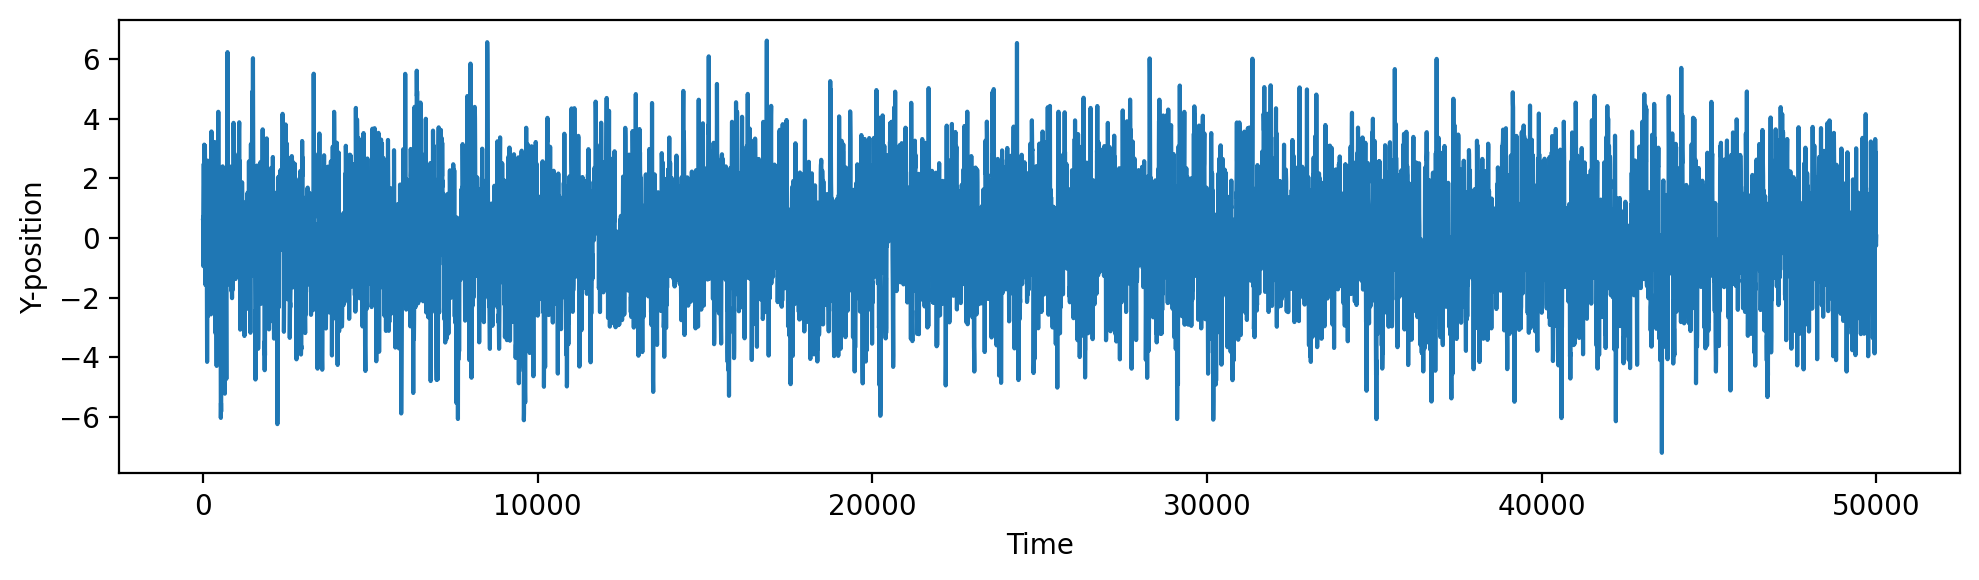

In [145]:
plt.figure(figsize=(10, 3))
plt.plot(times, positions[:, 1])
plt.xlabel("Time")
plt.ylabel("Y-position")
plt.tight_layout()
plt.savefig("y_time.png", dpi=600)
plt.show()

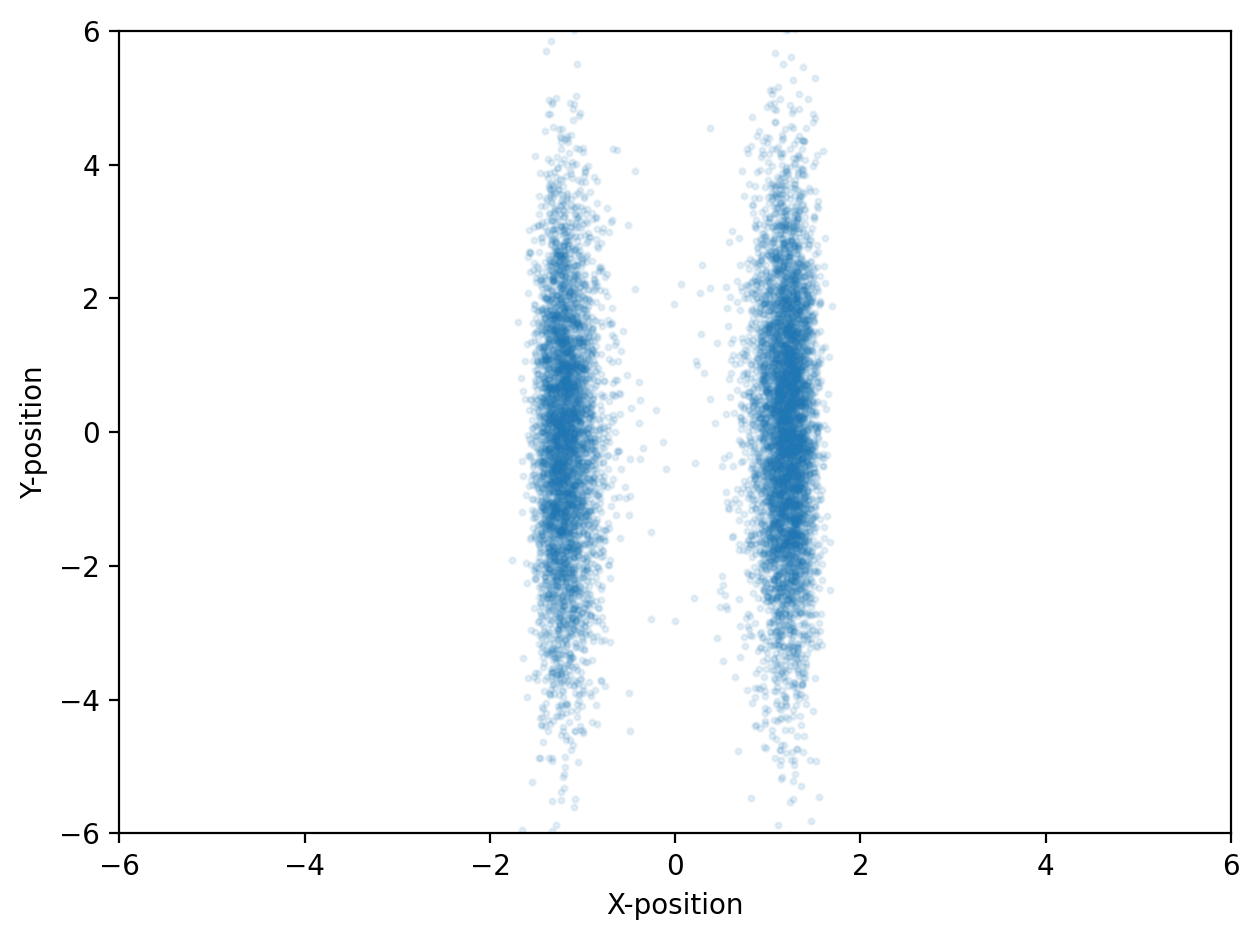

In [146]:
plt.scatter(positions[:, 0], positions[:, 1], alpha=0.1, s=4, label="Position Data")
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel("X-position")
plt.ylabel("Y-position")
plt.tight_layout()
plt.savefig("x_y.png", dpi=600)
plt.show()

### Principal Component Analysis

In [147]:
positions_projected, eigenvecs = pca(positions, 2)
center = np.mean(positions, axis=0)
first_eigen, second_eigen = eigenvecs[:, 0], eigenvecs[:, 1]

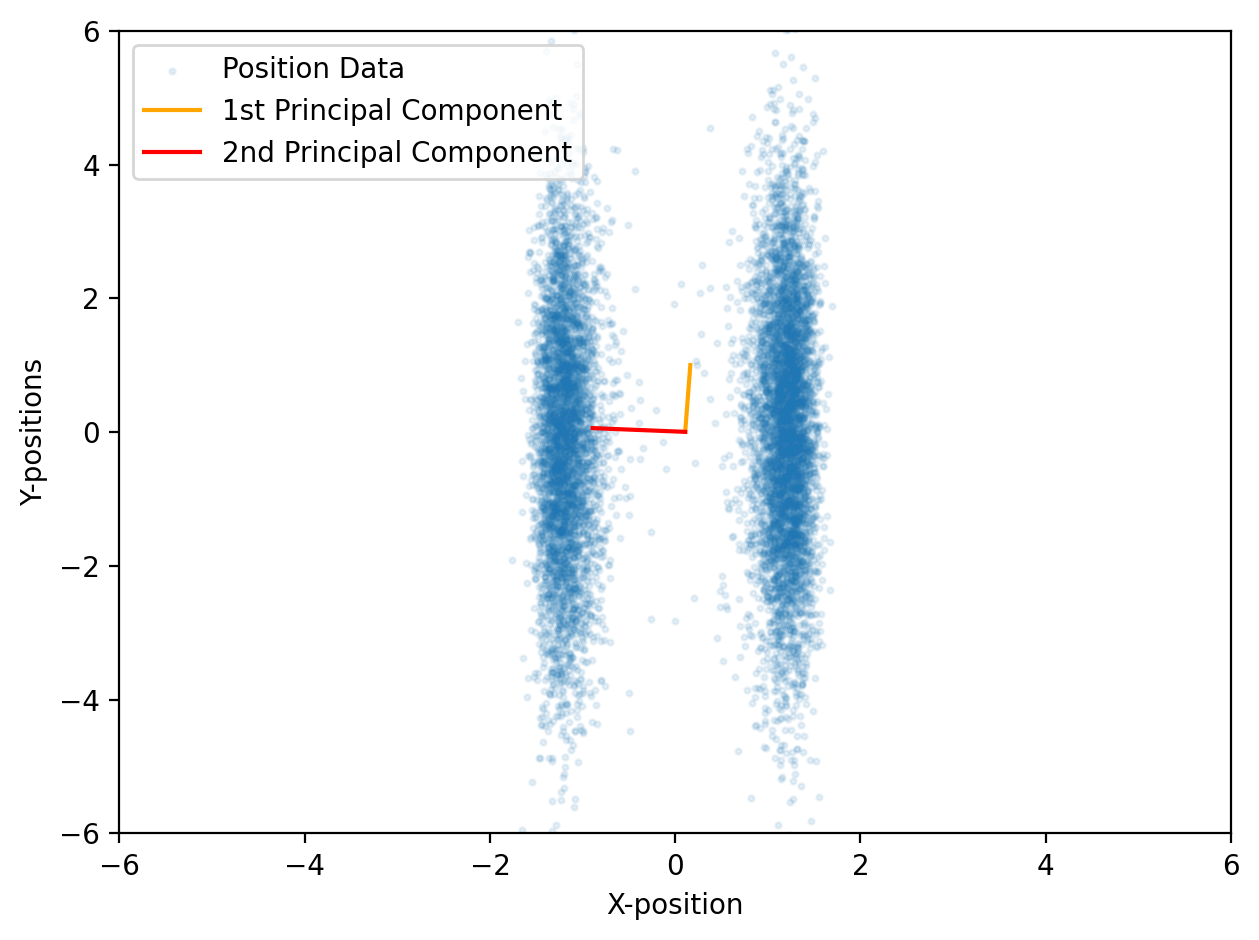

In [148]:
plt.scatter(positions[:, 0], positions[:, 1], alpha=0.1, s=4, label="Position Data")
plt.plot([center[0], center[0]+first_eigen[0]], [center[1], center[1]+first_eigen[1]], c="orange", label="1st Principal Component")
plt.plot([center[0], center[0]+second_eigen[0]], [center[1], center[1]+second_eigen[1]], c="red", label="2nd Principal Component")
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel("X-position")
plt.ylabel("Y-positions")
plt.legend()
plt.tight_layout()
plt.savefig("x_y_pca.png", dpi=600)
plt.show()

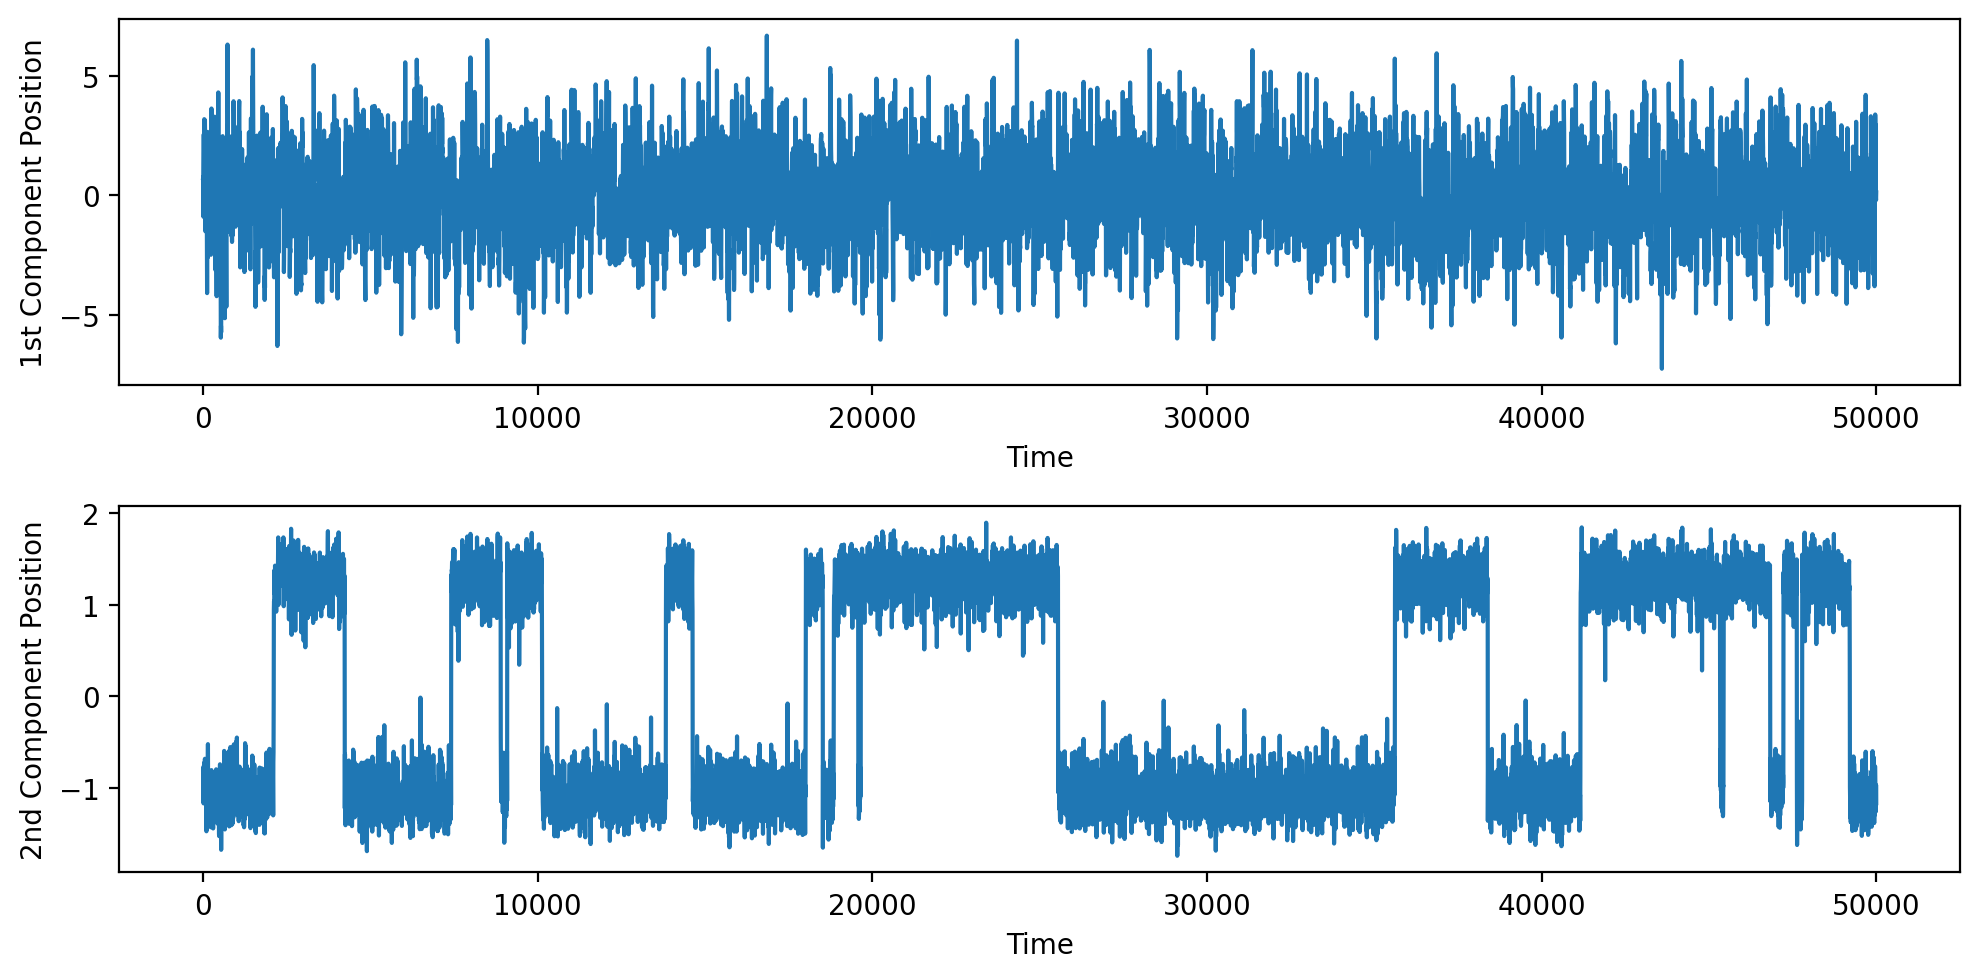

In [149]:
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(times, positions_projected[:, 0])
plt.ylabel("1st Component Position")
plt.xlabel("Time")
plt.subplot(2, 1, 2)
plt.plot(times, positions_projected[:, 1])
plt.ylabel("2nd Component Position")
plt.xlabel("Time")
plt.tight_layout()
plt.savefig("components_time.png", dpi=600)
plt.show()

## Z-Potential

In [153]:
def Zpot(r):
    x, y = r
    term1 = (x**4 + y**4) / 20480
    term2 = -3 * np.exp(-0.01 * (x + 5)**2 - 0.2 * (y + 5)**2)
    term3 = -3 * np.exp(-0.01 * (x - 5)**2 - 0.2 * (y - 5)**2)
    term4 = 5 * np.exp(-0.2 * (x + 3 * (y - 3))**2) / (1 + np.exp(-x - 3))
    term5 = 5 * np.exp(-0.2 * (x + 3 * (y + 3))**2) / (1 + np.exp(x - 3))
    term6 = 3 * np.exp(-0.01 * (x**2 + y**2))
    
    return term1 + term2 + term3 + term4 + term5 + term6   

def Z_derivatives():
    x, y = symbols('x y')
    
    term1 = (x**4 + y**4) / 20480
    term2 = -3 * exp(-0.01 * (x + 5)**2 - 0.2 * (y + 5)**2)
    term3 = -3 * exp(-0.01 * (x - 5)**2 - 0.2 * (y - 5)**2)
    term4 = 5 * exp(-0.2 * (x + 3 * (y - 3))**2) / (1 + exp(-x - 3))
    term5 = 5 * exp(-0.2 * (x + 3 * (y + 3))**2) / (1 + exp(x - 3))
    term6 = 3 * exp(-0.01 * (x**2 + y**2))
    
    V = term1 + term2 + term3 + term4 + term5 + term6
    
    dZdx_xy = lambdify((x, y), diff(V, x), "numpy")
    dZdy_xy = lambdify((x, y), diff(V, y), "numpy")
    dZdx_r = lambda r: dZdx_xy(r[0], r[1])
    dZdy_r = lambda r: dZdy_xy(r[0], r[1])

    return dZdx_r, dZdy_r

dZdx, dZdy = Z_derivatives()

def Z_inA(r):
    return (r[0] < -4.0) and (r[1] < -3.0)

def Z_inB(r):
    return (r[0] > 4.0) and (r[1] > 3.0)

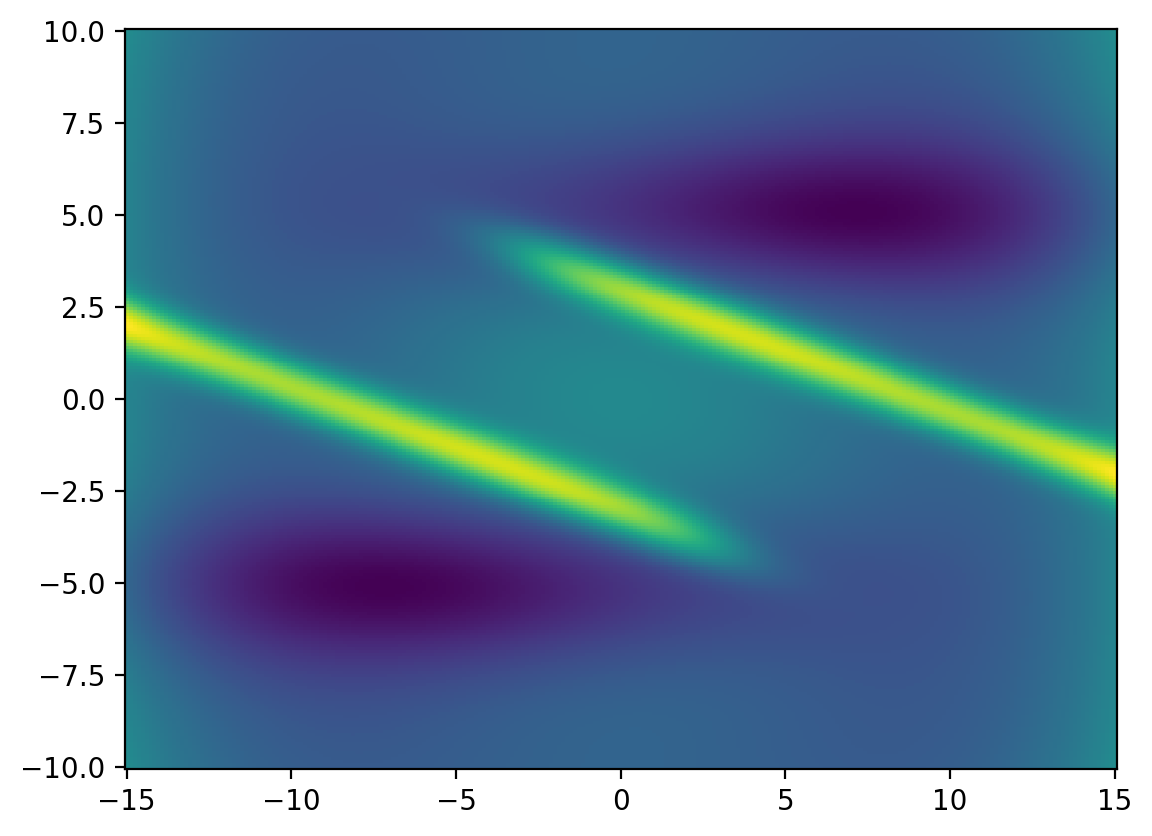

In [173]:
x = np.linspace(-15, 15, 250)
y = np.linspace(-10, 10, 250)
r = np.meshgrid(x, y)

plt.pcolormesh(x, y, Zpot(r))
plt.savefig("zpot_img.png", dpi=600)
plt.show()

In [155]:
mdsim_zpot = MDSimulation(
    0.05,
    1.5,
    1.0,
    dZdx,
    dZdy,
    Ekin,
    Z_inA,
    Z_inB
)
zpot_positions = mdsim_zpot.run(total_steps=10_000_000, print_steps=1_000_000, position_steps=1_000)

x = 6.803, y = 5.012, average beta = [2.99239364e-12 2.98761842e-12], A = False, B = True
x = -3.784, y = -5.848, average beta = [7.46049711e-13 7.47139988e-13], A = False, B = False
x = 4.355, y = 4.865, average beta = [3.32622947e-13 3.32139743e-13], A = False, B = True
x = -9.283, y = -5.134, average beta = [1.87101803e-13 1.87318158e-13], A = True, B = False
x = 10.539, y = 6.406, average beta = [1.19714838e-13 1.19963152e-13], A = False, B = True
x = 1.550, y = 5.198, average beta = [8.30346493e-14 8.34079685e-14], A = False, B = False
x = -8.741, y = -5.721, average beta = [6.11143207e-14 6.13104857e-14], A = True, B = False
x = -8.869, y = -5.962, average beta = [4.67251955e-14 4.68658842e-14], A = True, B = False
x = -8.783, y = -5.201, average beta = [3.68977957e-14 3.69956123e-14], A = True, B = False
x = 8.161, y = 6.121, average beta = [2.98959731e-14 2.99613408e-14], A = False, B = True


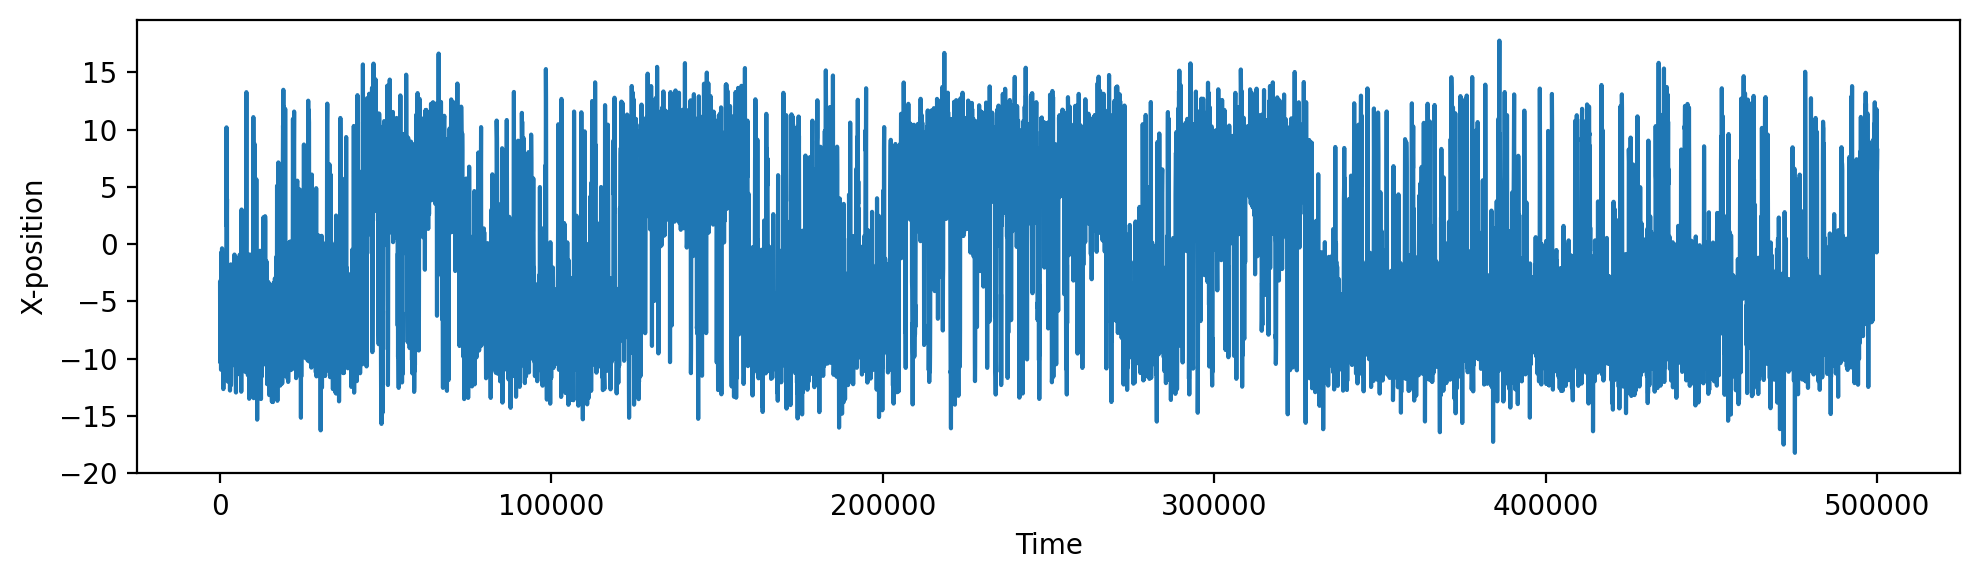

In [156]:
zpot_times = np.linspace(0, 0.05*10_000_000, 10_000)
plt.figure(figsize=(10, 3))
plt.plot(zpot_times, zpot_positions[:, 0])
plt.xlabel("Time")
plt.ylabel("X-position")
plt.tight_layout()
plt.savefig("zpot_x_time.png", dpi=600)
plt.show()

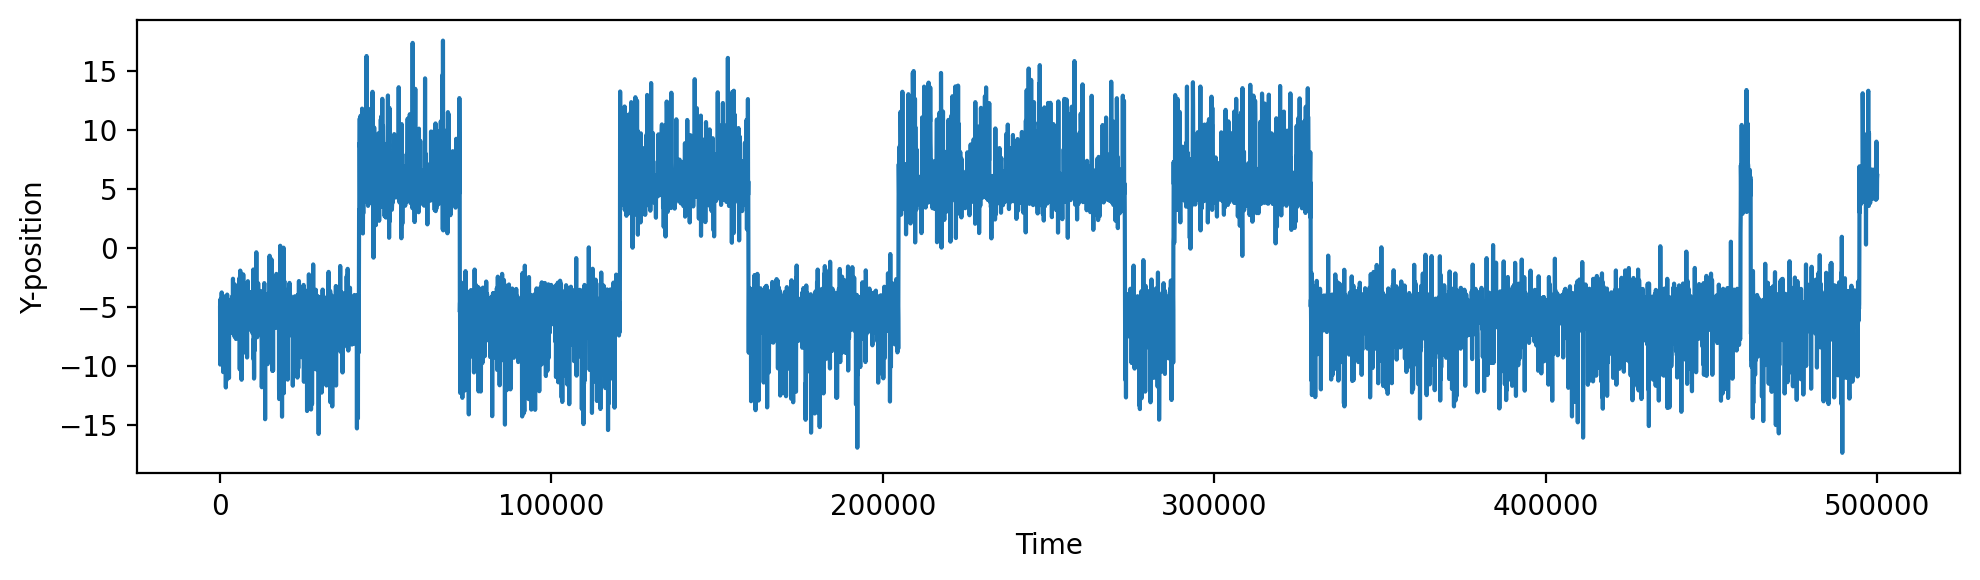

In [157]:
plt.figure(figsize=(10, 3))
plt.plot(zpot_times, zpot_positions[:, 1])
plt.xlabel("Time")
plt.ylabel("Y-position")
plt.tight_layout()
plt.savefig("zpot_y_time.png", dpi=600)
plt.show()

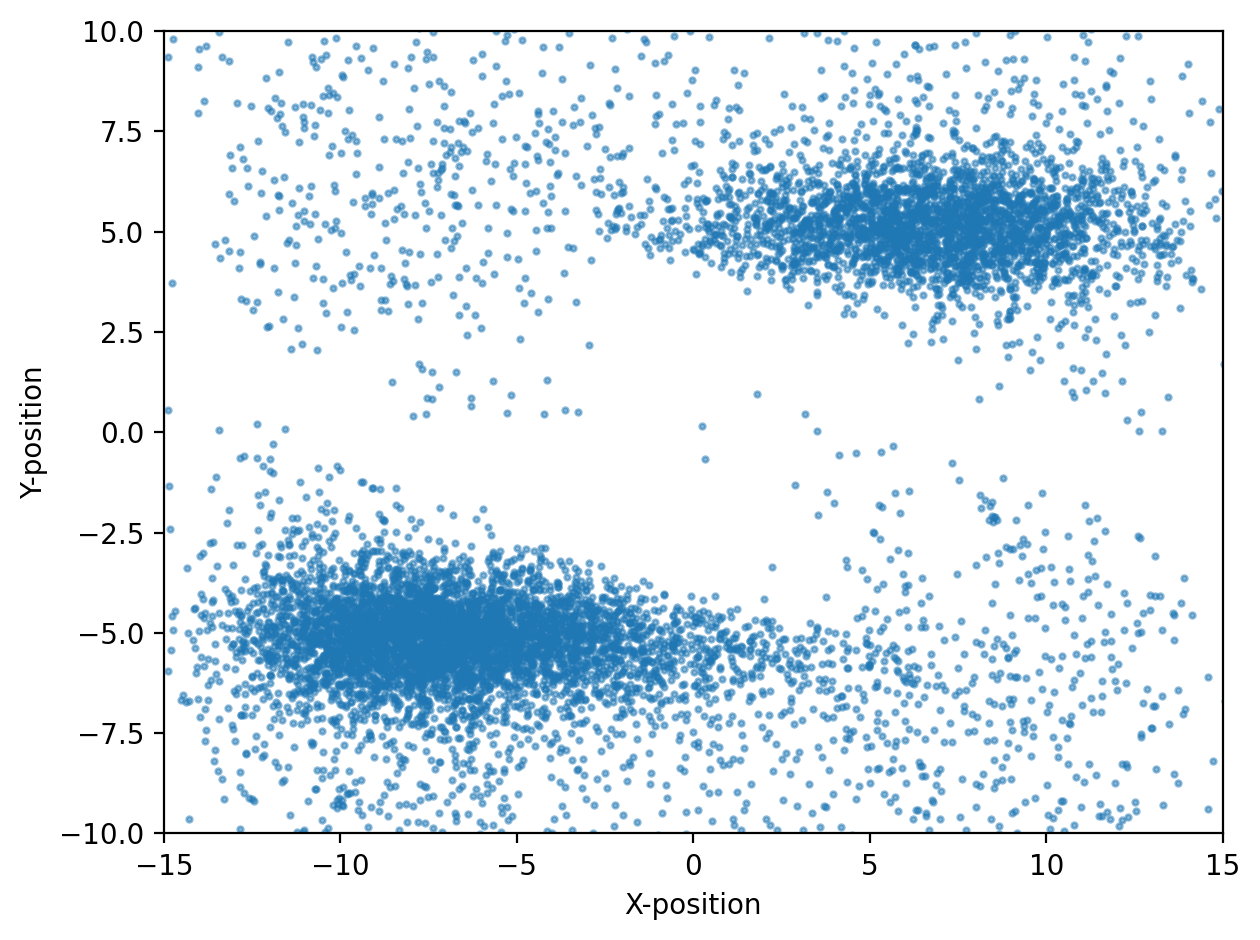

In [160]:
plt.scatter(zpot_positions[:, 0], zpot_positions[:, 1], alpha=0.5, s=4, label="Position Data")
plt.xlim(-15, 15)
plt.ylim(-10, 10)
plt.xlabel("X-position")
plt.ylabel("Y-position")
plt.tight_layout()
plt.savefig("zpot_x_y.png", dpi=600)
plt.show()

In [175]:
zpot_positions_projected, zpot_eigenvecs = pca(zpot_positions, 2)
zpot_center = np.mean(zpot_positions, axis=0)
zpot_first_eigen, zpot_second_eigen = zpot_eigenvecs[:, 0], zpot_eigenvecs[:, 1]

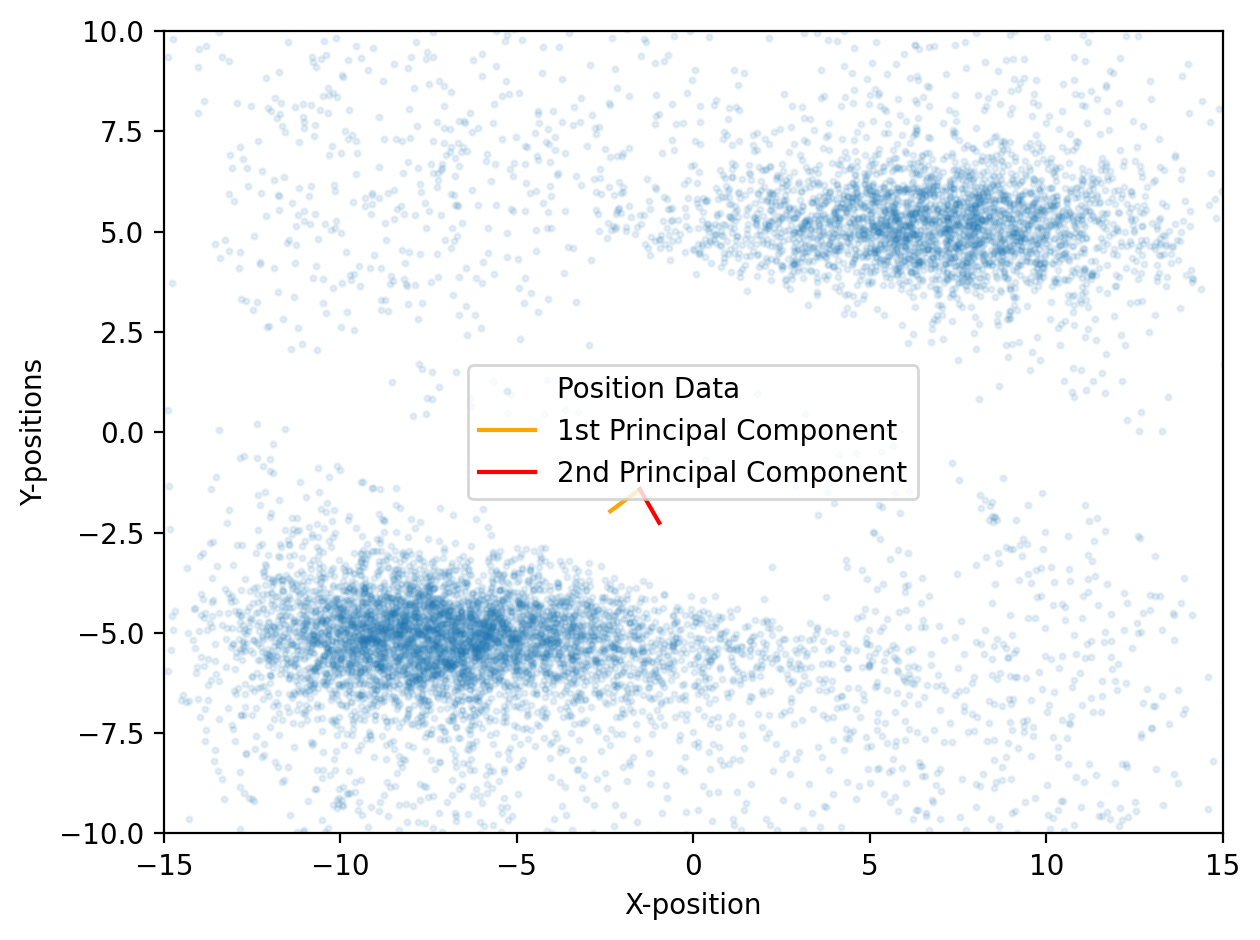

In [176]:
plt.scatter(zpot_positions[:, 0], zpot_positions[:, 1], alpha=0.1, s=4, label="Position Data")
plt.plot([zpot_center[0], zpot_center[0]+zpot_first_eigen[0]], [zpot_center[1], zpot_center[1]+zpot_first_eigen[1]], c="orange", label="1st Principal Component")
plt.plot([zpot_center[0], zpot_center[0]+zpot_second_eigen[0]], [zpot_center[1], zpot_center[1]+zpot_second_eigen[1]], c="red", label="2nd Principal Component")
plt.xlim(-15, 15)
plt.ylim(-10, 10)
plt.xlabel("X-position")
plt.ylabel("Y-positions")
plt.legend()
plt.tight_layout()
plt.savefig("zpot_x_y_pca.png", dpi=600)
plt.show()

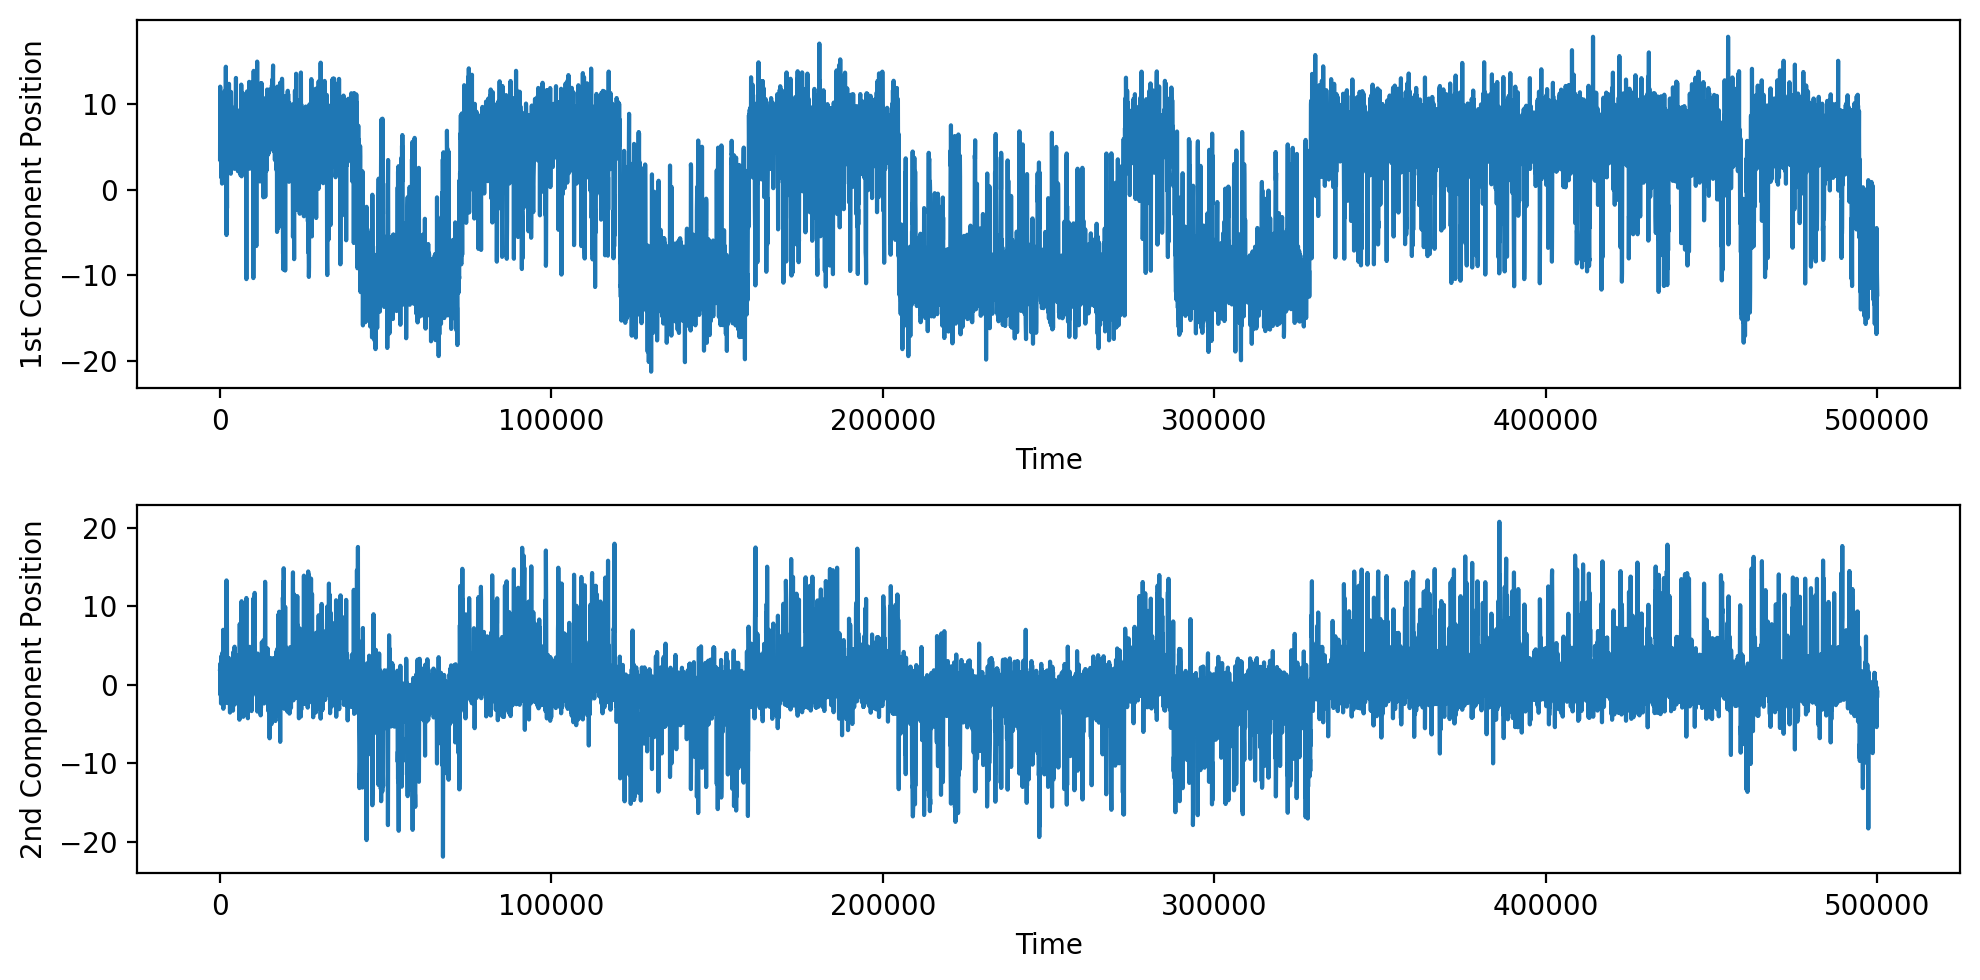

In [177]:
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(zpot_times, zpot_positions_projected[:, 0])
plt.ylabel("1st Component Position")
plt.xlabel("Time")
plt.subplot(2, 1, 2)
plt.plot(zpot_times, zpot_positions_projected[:, 1])
plt.ylabel("2nd Component Position")
plt.xlabel("Time")
plt.tight_layout()
plt.savefig("zpot_components_time.png", dpi=600)
plt.show()